# Trp-cage

In [2]:
import pyemma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import multiprocessing
from collections import Counter
import copy
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

# NMM modules
import sys
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
from nmm import NonMarkovModel, MarkovPlusColorModel, DiscretePathEnsemble

## Auxiliary functions

In [147]:
def get_tps(trajs, ini_state, final_state, n_states, misfolded_state=[]):
    
    macro_dict = dict()
    for micro in ini_state:
        macro_dict[micro] = 0
    for micro in final_state:
        macro_dict[micro] = 2
    for micro in [x for x in range(n_states) if x not in ini_state+final_state]:
        macro_dict[micro] = 1
    
    tps_list=[]
    for traj in trajs:
        if isinstance(traj, np.ndarray): traj = traj.tolist()
        macro_traj = list(map(macro_dict.get, traj))
        tp=[]
        for i in range(0,len(macro_traj)):
            if macro_traj[i] == 0:
                tp = [traj[i]]
            elif macro_traj[i] == 2 and len(tp)>0:
                tp.append(traj[i])
                tps_list.append(np.array(tp))
                tp=[]
            elif len(tp)>0:
                tp.append(traj[i])
                
    if misfolded_state:
        tps_list_ = []
        for tps in tps_list:
            if not [microst for microst in tps if microst in misfolded_state]:
                tps_list_.append(tps)
        tps_list = tps_list_
                
    return(tps_list)

def _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state=[]):
    
    # keep only intermediate fragments (of indirect paths) for counts and mean_length
    tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])

    # pdirect
    pdirect = len([path for path in tps if len(path) == 2]) / len(tps)

    # mean path length (length of direct paths taken to be zero)
    mean_length = np.sum([len(path) for path in tps_indir]) / len(tps)
    if mean_length == 0: mean_length = np.nan

    # counts (indirect only)
    if len(tps_indir) == 0:
        print('There are no indirect TPs!')
        return pdirect, mean_length, np.nan
    tps_indir_concat = np.concatenate(tps_indir)
    counter = Counter(tps_indir_concat)
    counts = [counter[i] for i in [x for x in range(n_states) if x not in stateA+stateB+misfolded_state]]
    counts = np.array(counts) / len(tps_indir_concat)

    return pdirect, mean_length, counts

def get_tps_stats(tps, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    if len(tps) == 0:
        print('There are no TPs!')
        return np.nan, np.nan, np.nan

    if bootstrap:
        bootstrap_counts = []
        bootstrap_pdirect = []
        bootstrap_mean_length = []
        for bootstrap_ in range(n_samples):
            tps_ = np.random.choice(tps, len(tps))
            
            pdirect, mean_length, counts = _get_tps_stats(tps_, stateA, stateB, n_states, misfolded_state)
            
            bootstrap_pdirect.append(pdirect)
            bootstrap_mean_length.append(mean_length)
            bootstrap_counts.append(counts)

        return bootstrap_pdirect, bootstrap_mean_length, bootstrap_counts
            
    else:
        return _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state)

def get_tps_w_stats(dtrajs, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    tps = get_tps(dtrajs, stateA, stateB, n_states, misfolded_state) + get_tps(dtrajs, stateB, stateA, n_states, misfolded_state)
    pdirect, mean_length, counts = get_tps_stats(tps, stateA, stateB, n_states, bootstrap, n_samples, misfolded_state)
    
    return tps, pdirect, mean_length, counts

def simulate_msm(msm, sim_traj_length=1000000):
    
    np.random.seed()
    traj = msm.simulate(sim_traj_length)
    
    return [traj]

def simulate_hamsm(nm_tmatrix, stateA, stateB, sim_traj_length=3000000):
    
    np.random.seed()
    sim = NonMarkovModel.from_nm_tmatrix(nm_tmatrix, stateA, stateB, sim_length=sim_traj_length, initial_state=stateA[0])
    trajs = sim.trajectories
    
    return trajs

def estimate_simulate_msm(dtrajs, lag, sim_traj_length=1000000):
    
    msm = pyemma.msm.estimate_markov_model(list(dtrajs), lag)
    trajs = simulate_msm(msm, sim_traj_length=sim_traj_length)
    
    return msm, trajs

def estimate_simulate_hamsm(dtrajs, stateA, stateB, hist_length='all', sim_traj_length=3000000):
    
    if hist_length == 'all':
        nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, clean_traj=True)
    else:
        nm_model = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, hist_length=hist_length, clean_traj=True)
    
    trajs = simulate_hamsm(nm_model.nm_tmatrix, stateA, stateB, sim_traj_length)
    
    return nm_model, trajs

def coarsegrain_paths(tps, state_dict, stateA, stateB):

    tps_coarse = []

    for path in tps:
        if isinstance(path, np.ndarray): path = path.tolist()
        path_ = []
        for state in path:
            if state in stateA:
                path_.append(state_dict['A'])
            elif state in stateB:
                path_.append(state_dict['B'])
            else:
                path_.append(state_dict[state])
        if path_[0] == state_dict['B']:
            path_ = path_[::-1]
        tps_coarse.append(path_)
        
    return tps_coarse

def get_fundamental_sequences(tps, stateA, stateB, nm_dict, markov_tmatrix, bootstrap=False, n_samples=1000):
    
    # keep only intermediate fragments (of indirect paths)
    tps_ = [path for path in tps if len(path) > 2]   
    tps_coarse = coarsegrain_paths(tps_, nm_dict, stateA, stateB)
    
    if bootstrap:
        bootstrap_FS = []
        bootstrap_FSweights = []
        for bootstrap in range(n_samples):
            tps_coarse_ = np.random.choice(tps_coarse, len(tps_coarse))
            
            ens = DiscretePathEnsemble(tps_coarse_, stateA=stateA, stateB=stateB)
            FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)
            
            bootstrap_FS.append(FS)
            bootstrap_FSweights.append(FSweights)
            
        return bootstrap_FS, bootstrap_FSweights    
    
    else:
        ens = DiscretePathEnsemble(tps_coarse, stateA=stateA, stateB=stateB)
        FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)

        return FS, FSweights
    
def get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict):
    
    FSweights_common = np.zeros(len(FS_md))

    for j,seq in enumerate(FS):
        if seq in FS_md_indexdict:
            FSweights_common[FS_md_indexdict[seq]] = FSweights[j]
            
    return FSweights_common

def abs_error(x,y):

    abs_error = np.sum(np.abs(x-y))
        
    return abs_error

## Read MD data

In [88]:
system_name = 'Trp-cage'

dtrajs = list(np.load('../../top_models/trpcage/trpcage_dtrajs.npy'))

msm = pyemma.msm.estimate_markov_model(dtrajs, 100*5)
pcca = msm.pcca(2)

# unfolded - more states
stateA_index = np.argmax([len(x) for x in pcca.metastable_sets])
# folded - fewer states
stateB_index = np.argmin([len(x) for x in pcca.metastable_sets])

cutoff = 0.5
intermediate_len = 0
while intermediate_len < 0.1*msm.nstates:
           
    cutoff += 0.0001 # adjust to make possible to get desired intermediate

    stateA = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
    stateB = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

    intermediate_len = msm.nstates - len(stateA) - len(stateB)   

In [89]:
print('Intermediate size: {}, cutoff: {}'.format(intermediate_len, cutoff))
print('Unfolded size: {}, folded size: {}'.format(len(stateA), len(stateB)))

Intermediate size: 5, cutoff: 0.9285999999999528
Unfolded size: 43, folded size: 2


## Estimate MSMs and simulate long trajectories

In [7]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

In [8]:
pool = multiprocessing.Pool(8)
out = pool.starmap(estimate_simulate_msm, [(dtrajs, lag) for lag in lags])
pool.close()
pool.join()

msms = [x[0] for x in out]
dtrajs_msms = [x[1] for x in out]
del out

np.save('{}_dtrajs_msms.npy'.format(system_name), dtrajs_msms)
# OR RELOAD
# dtrajs_msms = np.load('{}_dtrajs_msms.npy'.format(system_name), allow_pickle=True)

## Estimate haMSMs and simulate long trajectories

In [90]:
remove_for_eq = int(np.mean([msms[7].mfpt(stateA, stateB), msms[7].mfpt(stateB, stateA)]))
dtrajs_nm = []

dtrajs_ = copy.deepcopy(dtrajs)
for traj in dtrajs_:
    dtrajs_nm.append(traj[remove_for_eq:])
    dtrajs_nm.append(traj[remove_for_eq:][::-1])

np.save('{}_dtrajs_nm.npy'.format(system_name), dtrajs_nm)
# OR RELOAD    
# dtrajs_nm = np.load('{}_dtrajs_nm.npy'.format(system_name), allow_pickle=True)

dtrajs_nm = [x.tolist() for x in dtrajs_nm]

In [10]:
hist_lengths = ['all', 5, 10, 20, 50, 250, 500]
pool = multiprocessing.Pool(7)
out = pool.starmap(estimate_simulate_hamsm, [(dtrajs_nm, stateA, stateB, hist_length) for hist_length in hist_lengths])
pool.close()
pool.join()

hamsms = [x[0] for x in out]
dtrajs_hamsms = [x[1] for x in out]
del out

np.save('{}_dtrajs_hamsms.npy'.format(system_name), dtrajs_hamsms)
# OR RELOAD
# dtrajs_hamsms = np.load('{}_dtrajs_hamsms.npy'.format(system_name), allow_pickle=True)

# 10 intermediate states: p(x|TP) (indirect paths only)

## MD

In [79]:
tps_md, pdirect_md, mean_length_md, counts_md = get_tps_w_stats(dtrajs, stateA, stateB, n_states=50, bootstrap=True, n_samples=1000)

In [80]:
len(tps_md), len([path for path in tps_md if len(path) > 2]) # all, and indirect paths only

(74, 64)

## MSMs

In [21]:
tps_msms = []
pdirect_msms = []
mean_length_msms = []
counts_msms = []

for dtrajs_ in dtrajs_msms:
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_, stateA, stateB, n_states=50)
    
    tps_msms.append(tps)
    pdirect_msms.append(pdirect)
    mean_length_msms.append(mean_length)
    counts_msms.append(counts)

In [65]:
# all paths
[len(tps) for tps in tps_msms]

[1216, 1701, 1987, 2342, 3132, 7126, 10850, 19069, 87188]

In [23]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_msms]

[1206, 1679, 1952, 2279, 2844, 5446, 7395, 11779, 19665]

## haMSMs

In [56]:
tps_hamsms = []
pdirect_hamsms = []
mean_length_hamsms = []
counts_hamsms = []

for dtrajs_ in dtrajs_hamsms:
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_, stateA, stateB, n_states=50)
    
    tps_hamsms.append(tps)
    pdirect_hamsms.append(pdirect)
    mean_length_hamsms.append(mean_length)
    counts_hamsms.append(counts)

In [57]:
# all paths
[len(tps) for tps in tps_hamsms]

[204, 937, 634, 445, 340, 199, 208]

In [58]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_hamsms]

[179, 910, 601, 412, 304, 178, 171]

## plot

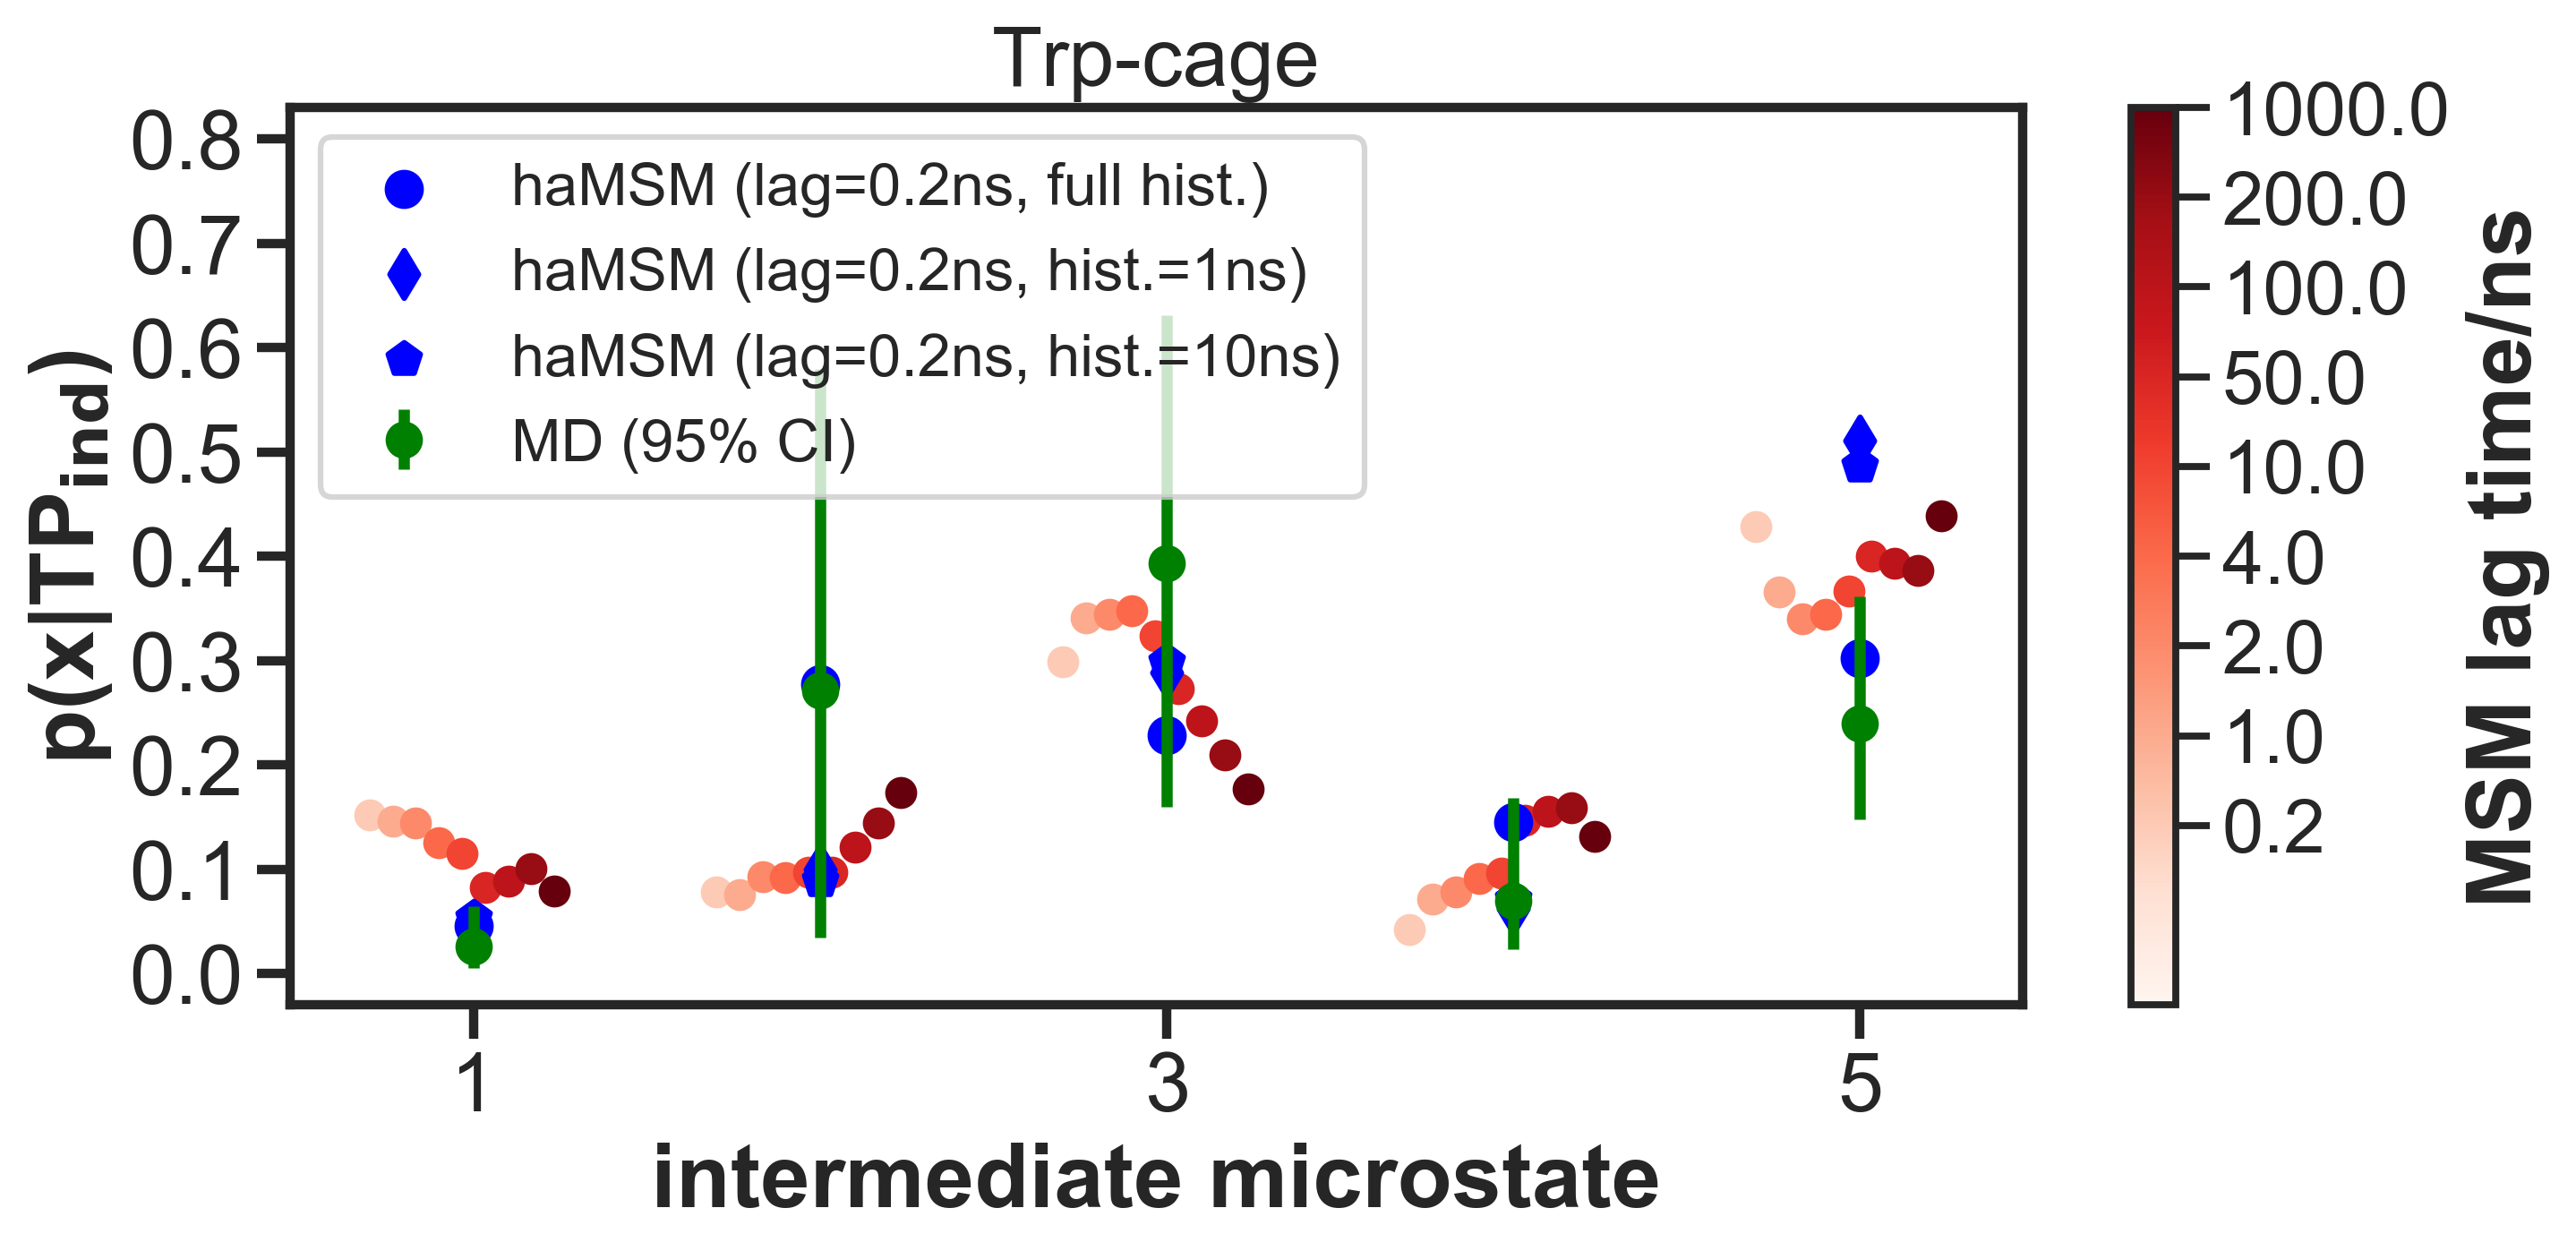

In [87]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(width=2.5)

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,5.5), counts_msms[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=24, weight='bold')
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,6), np.mean(counts_md, axis=0), 
             yerr=[(np.mean(counts_md, axis=0)-np.percentile(counts_md, 2.5, axis=0)), 
                   (np.percentile(counts_md, 97.5, axis=0)-np.mean(counts_md, axis=0))], 
             color='green', label='MD (95% CI)', fmt='o', elinewidth=3)

plt.scatter(np.arange(1,6), counts_hamsms[0], color='blue', label='haMSM (lag=0.2ns, full hist.)', marker='o')
plt.scatter(np.arange(1,6), counts_hamsms[1], color='blue', label='haMSM (lag=0.2ns, hist.=1ns)', marker='d')
plt.scatter(np.arange(1,6), counts_hamsms[4], color='blue', label='haMSM (lag=0.2ns, hist.=10ns)', marker='p')

plt.xlabel('intermediate microstate', fontsize=24, weight='bold')
plt.ylabel('p(x|TP$_\mathbf{ind}$)', fontsize=24, weight='bold')
plt.xticks(np.arange(1,6,2), np.arange(1,6,2), fontsize=22)
plt.yticks(np.arange(0, 0.9, 0.1), fontsize=22)
plt.ylim(-0.03, 0.83)
plt.title('{}'.format(system_name), fontsize=22)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig('{}_pxTP_main.pdf'.format(system_name))

plt.show()

# 10 intermediate states: fundamental sequences (indirect paths only)

## new haMSM estimation with coarse macrostates

In [91]:
dtrajs_nm_ = copy.deepcopy(dtrajs_nm) # coarse_macrostates = True modifies dtrajs
nm_model = NonMarkovModel(dtrajs_nm_, stateA, stateB, lag_time=1, coarse_macrostates=True) 

In [92]:
# make micro --> macro dictionary for path coarse-graining
nm_dict = dict()
nm_dict['A'] = nm_model.stateA[0]
nm_dict['B'] = nm_model.stateB[0]

for i in range(len(dtrajs_nm[0])):
    if len(nm_dict) == nm_model.n_states:
        break
    if dtrajs_nm[0][i] not in stateA+stateB:  
        nm_dict[dtrajs_nm[0][i]] = nm_model.trajectories[0][i]

## MD 

In [93]:
FS_md, FSweights_md = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix)

FS_md_bootstrap, FSweights_md_bootstrap = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix, bootstrap=True, n_samples=1000)

## MSMs

In [94]:
FS_msms = []
FSweights_msms = []

for i,tps in enumerate(tps_msms):
    nm_model.lag_time = lags[i]
    FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
    FS_msms.append(FS)
    FSweights_msms.append(FSweights)       

nm_model.lag_time = 1    

## haMSMs

In [95]:
FS_hamsms = []
FSweights_hamsms = []

for i,tps in enumerate(tps_hamsms):
    FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
    FS_hamsms.append(FS)
    FSweights_hamsms.append(FSweights)   

## find common fundamental sequences

In [96]:
FS_md_indexdict = dict()
for i,seq in enumerate(FS_md):
    FS_md_indexdict[seq] = i

# MD
FSweights_md_bootstrap_common = []
for i in range(len(FS_md_bootstrap)):
    FS = FS_md_bootstrap[i]
    FSweights = FSweights_md_bootstrap[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
    FSweights_md_bootstrap_common.append(FSweights_common)            

# MSMs
FSweights_msms_common = []
for i in range(len(FS_msms)):
    FS = FS_msms[i]
    FSweights = FSweights_msms[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict) 
    FSweights_msms_common.append(FSweights_common)    

# haMSMs
FSweights_hamsms_common = []
for i in range(len(FS_hamsms)):
    FS = FS_hamsms[i]
    FSweights = FSweights_hamsms[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
    FSweights_hamsms_common.append(FSweights_common)     

## plot

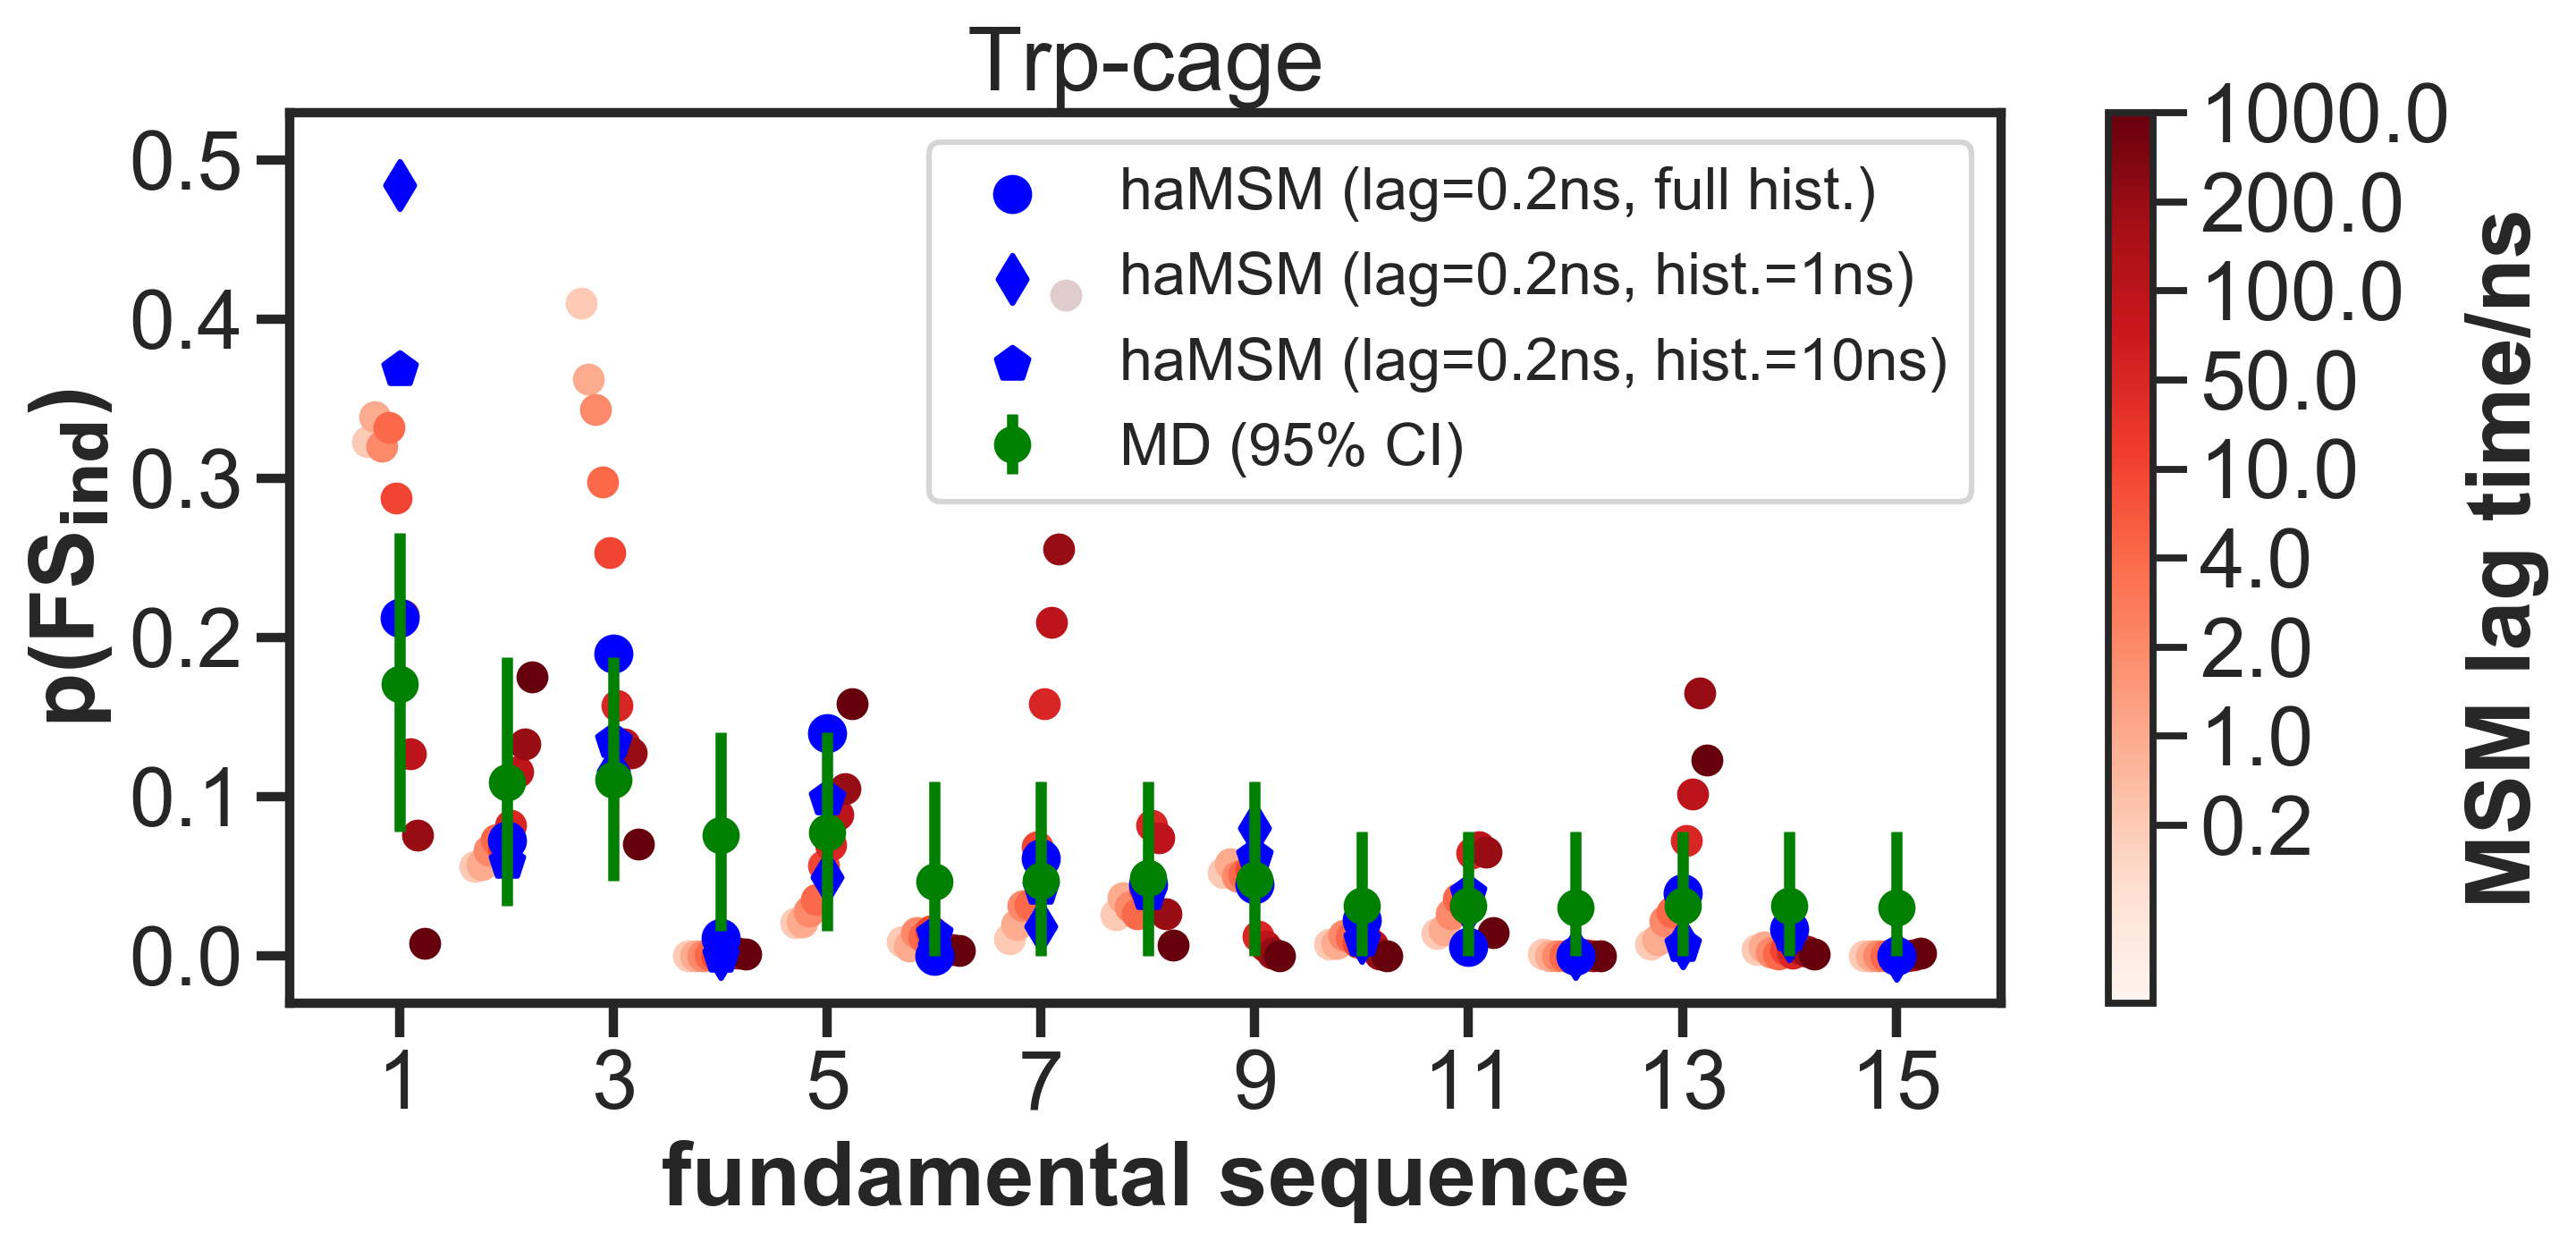

In [110]:
no_paths = 15

fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(width=2.5)

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,no_paths+0.5), 
                FSweights_msms_common[msm_index][:no_paths], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=24, weight='bold')
cbar.ax.tick_params(labelsize=22)

plt.errorbar(range(1,no_paths+1), np.mean(FSweights_md_bootstrap_common, axis=0)[:no_paths], 
             yerr=[(np.mean(FSweights_md_bootstrap_common, axis=0)-np.percentile(FSweights_md_bootstrap_common, 2.5, axis=0))[:no_paths], 
                   (np.percentile(FSweights_md_bootstrap_common, 97.5, axis=0)-np.mean(FSweights_md_bootstrap_common, axis=0))[:no_paths]], 
             color='green', label='MD (95% CI)', fmt='o', elinewidth=3)

plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[0][:no_paths], color='blue', label='haMSM (lag=0.2ns, full hist.)', marker='o')
plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[1][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=1ns)', marker='d')
plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[4][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=10ns)', marker='p')

plt.xlabel('fundamental sequence', fontsize=24, weight='bold')
plt.ylabel('p(FS$_\mathbf{ind}$)', fontsize=24, weight='bold')
plt.xticks(np.arange(1,no_paths+1,2), np.arange(1,no_paths+1,2), fontsize=22)
plt.yticks(np.arange(0, 0.6, 0.1), fontsize=22)
plt.ylim(-0.03, 0.53)
plt.title('{}'.format(system_name), fontsize=24)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig('{}_pFS_main.pdf'.format(system_name))

plt.show()

# Multiple numbers of intermediate states, stride = 0.2 ns

## choose PCCA cutoffs 

In [111]:
stateAs = []
stateBs = []
intermediate_lens = []

for i in np.arange(0.05, 0.8, 0.1):

    cutoff = 0.5
    intermediate_len = 0
    while intermediate_len < i*msm.nstates:
        
        cutoff += 0.0001 # adjust to make possible to get 10% intermediate

        stateA_ = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
        stateB_ = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

        intermediate_len = msm.nstates - len(stateA_) - len(stateB_) 
        
    stateAs.append(stateA_)
    stateBs.append(stateB_)
    intermediate_lens.append(intermediate_len)

intermediate_lens = np.array(intermediate_lens)

In [112]:
intermediate_lens

array([ 3,  8, 13, 18, 23, 28, 33, 38])

## MD

In [113]:
tps_md_cutoffs = []
pdirect_md_cutoffs = []
length_md_cutoffs = []
counts_md_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs, stateA_, stateB_, n_states=100, bootstrap=True, n_samples=1000)

    tps_md_cutoffs.append(tps)
    pdirect_md_cutoffs.append(pdirect)
    length_md_cutoffs.append(mean_length)
    counts_md_cutoffs.append(counts)

In [114]:
# all paths
[len(tps) for tps in tps_md_cutoffs]

[718, 36, 36, 36, 34, 34, 34, 34]

In [115]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_md_cutoffs]

[63, 36, 36, 36, 34, 34, 34, 34]

## MSMs

In [116]:
tps_msms_cutoffs = []
pdirect_msms_cutoffs = []
length_msms_cutoffs = []
counts_msms_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=100)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs.append(tps_)
    pdirect_msms_cutoffs.append(pdirect_)
    length_msms_cutoffs.append(length_)
    counts_msms_cutoffs.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs = [x * lags for x in length_msms_cutoffs]

In [118]:
# all paths
for i in range(len(intermediate_lens)):
    print([len(tps) for tps in tps_msms_cutoffs[i]])

[1280, 1783, 2069, 2414, 3220, 7216, 11024, 19407, 87904]
[1216, 1689, 1969, 2334, 3108, 7072, 10782, 18935, 86776]
[1204, 1673, 1955, 2334, 3096, 7054, 10770, 18845, 85932]
[1200, 1659, 1945, 2324, 3092, 7046, 10754, 18799, 84976]
[1198, 1651, 1931, 2320, 3088, 7028, 10724, 18673, 83428]
[1190, 1647, 1929, 2312, 3080, 7000, 10686, 18543, 81072]
[1188, 1635, 1917, 2294, 3056, 6932, 10544, 18199, 76698]
[1166, 1605, 1875, 2240, 2992, 6762, 10298, 17657, 72627]


In [119]:
# indirect paths only
for i in range(len(intermediate_lens)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs[i]])

[685, 1031, 1227, 1512, 1963, 4194, 5719, 9036, 15104]
[1216, 1688, 1962, 2323, 2983, 5866, 8209, 13491, 23447]
[1204, 1673, 1955, 2334, 3031, 6217, 8911, 14571, 31096]
[1200, 1659, 1945, 2324, 3033, 6344, 9227, 15174, 37595]
[1198, 1651, 1931, 2320, 3033, 6515, 9669, 16107, 45666]
[1190, 1647, 1929, 2312, 3025, 6563, 9901, 16739, 53011]
[1188, 1635, 1917, 2294, 3018, 6578, 10028, 17127, 59001]
[1166, 1605, 1875, 2240, 2978, 6723, 10153, 17268, 59484]


## haMSMs: estimate and simulate

In [120]:
pool = multiprocessing.Pool(8)

arguments = []
for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    arguments.append((dtrajs_nm, stateA_, stateB_, 'all'))

out = pool.starmap(estimate_simulate_hamsm, arguments)
pool.close()
pool.join()

hamsms_cutoffs = [x[0] for x in out]
dtrajs_hamsms_cutoffs = [x[1] for x in out]
del out

np.save('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), dtrajs_hamsms_cutoffs)
# OR RELOAD
# dtrajs_hamsms_cutoffs = np.load('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), allow_pickle=True)

## haMSMs: count

In [121]:
tps_hamsms_cutoffs = []
pdirect_hamsms_cutoffs = []
length_hamsms_cutoffs = []
counts_hamsms_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_hamsms_cutoffs[i], stateA_, stateB_, n_states=100)

    tps_hamsms_cutoffs.append(tps)
    pdirect_hamsms_cutoffs.append(pdirect)
    length_hamsms_cutoffs.append(mean_length)
    counts_hamsms_cutoffs.append(counts)

In [122]:
# all paths
[len(tps) for tps in tps_hamsms_cutoffs]

[1008, 112, 104, 106, 94, 106, 92, 118]

In [123]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_hamsms_cutoffs]

[149, 112, 104, 106, 94, 106, 92, 118]

## plot: p(direct TP)

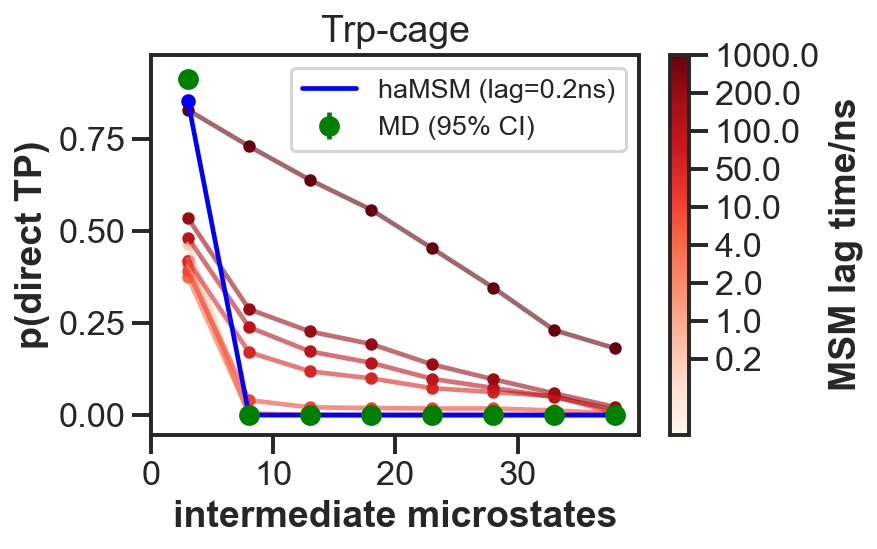

In [128]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = [i[msm_index] for i in pdirect_msms_cutoffs]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
plt.xticks(range(0,40,10))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

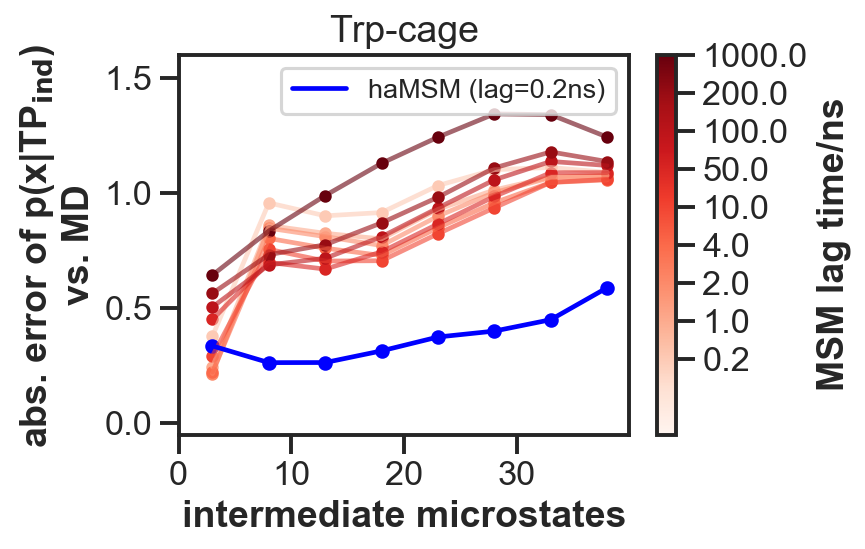

In [133]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs[i][msm_index]) for i in range(len(counts_msms_cutoffs))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')    

plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('abs. error of p(x|TP$_\mathbf{ind}$) \nvs. MD', weight='bold')
plt.xticks(range(0,40,10))
plt.ylim(-0.05,1.6)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: mean TP length (indirect paths only)

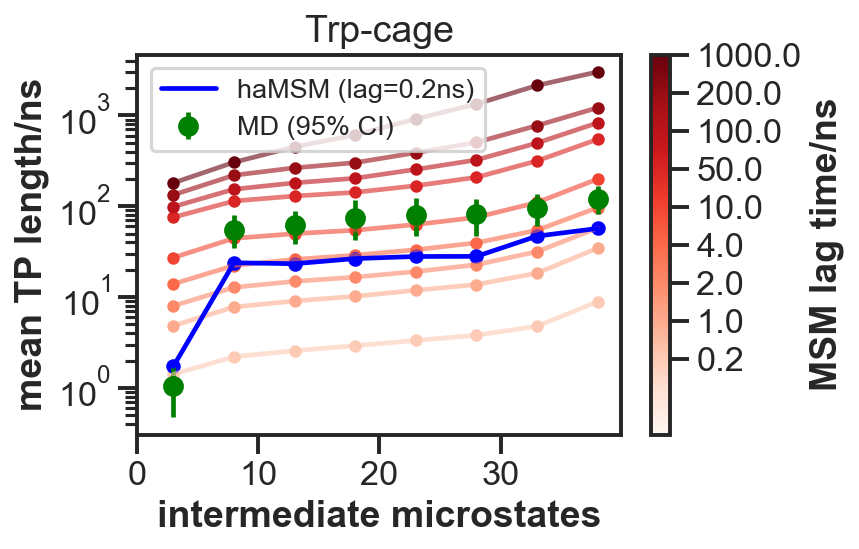

In [136]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,40,10))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13, loc='upper left')

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates.pdf'.format(system_name))

plt.show()

# Multiple numbers of intermediate states, MSMs trained on stride = lag

## MSMs: estimate and simulate

In [137]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

pool = multiprocessing.Pool(8)
out = pool.starmap(estimate_simulate_msm, ([([dtrajs[0][::lag]], 1) for lag in lags]))
pool.close()
pool.join()

msms_strides = [x[0] for x in out]
dtrajs_msms_strides = [x[1] for x in out]
del out

np.save('{}_dtrajs_msms_strides.npy'.format(system_name), dtrajs_msms_strides)
# OR RELOAD
# dtrajs_msms_strides = np.load('{}_dtrajs_msms_strides.npy'.format(system_name), allow_pickle=True)

## MSMs: count

In [148]:
tps_msms_cutoffs_strides = []
pdirect_msms_cutoffs_strides = []
length_msms_cutoffs_strides = []
counts_msms_cutoffs_strides = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms_strides:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=100)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs_strides.append(tps_)
    pdirect_msms_cutoffs_strides.append(pdirect_)
    length_msms_cutoffs_strides.append(length_)
    counts_msms_cutoffs_strides.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs_strides = [x * lags for x in length_msms_cutoffs_strides]

There are no indirect TPs!


In [149]:
# all paths
for i in range(len(intermediate_lens)):
    print([len(tps) for tps in tps_msms_cutoffs_strides[i]])

[1384, 1882, 2112, 2492, 3190, 7134, 11538, 23291, 57508]
[1314, 1782, 1994, 2378, 3080, 6996, 11278, 22325, 51928]
[1290, 1762, 1982, 2354, 3070, 6976, 11202, 21825, 50508]
[1280, 1746, 1974, 2346, 3060, 6962, 11150, 21789, 49306]
[1272, 1740, 1970, 2342, 3048, 6960, 11098, 21571, 49214]
[1272, 1736, 1962, 2334, 3034, 6928, 11016, 21361, 49110]
[1272, 1728, 1954, 2324, 3016, 6862, 10884, 20865, 48782]
[1250, 1708, 1906, 2274, 2954, 6712, 10646, 20203, 44414]


In [150]:
# indirect paths only
for i in range(len(intermediate_lens)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs_strides[i]])

[730, 1013, 1190, 1561, 1767, 3543, 5885, 8915, 0]
[1314, 1776, 1989, 2350, 2976, 5343, 8919, 15539, 18395]
[1290, 1762, 1982, 2354, 3014, 6011, 9306, 18906, 26711]
[1280, 1746, 1974, 2346, 3004, 6231, 9741, 18870, 34999]
[1272, 1740, 1970, 2342, 2992, 6229, 10154, 19636, 34907]
[1272, 1736, 1962, 2334, 2978, 6435, 10072, 19426, 34803]
[1272, 1728, 1954, 2324, 2960, 6369, 9940, 19893, 34475]
[1250, 1708, 1906, 2274, 2954, 6712, 10157, 19231, 34934]


## plot: p(direct TP)

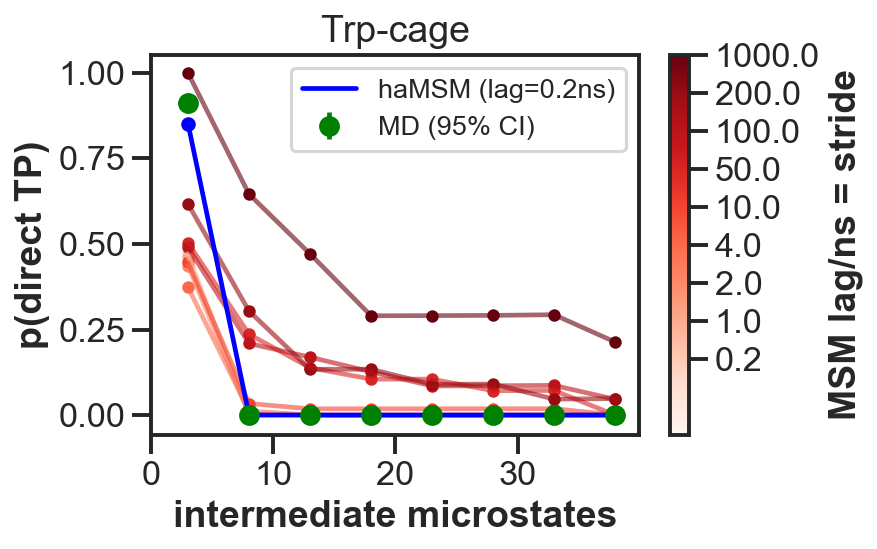

In [142]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = [i[msm_index] for i in pdirect_msms_cutoffs_strides]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
plt.xticks(range(0,40,10))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

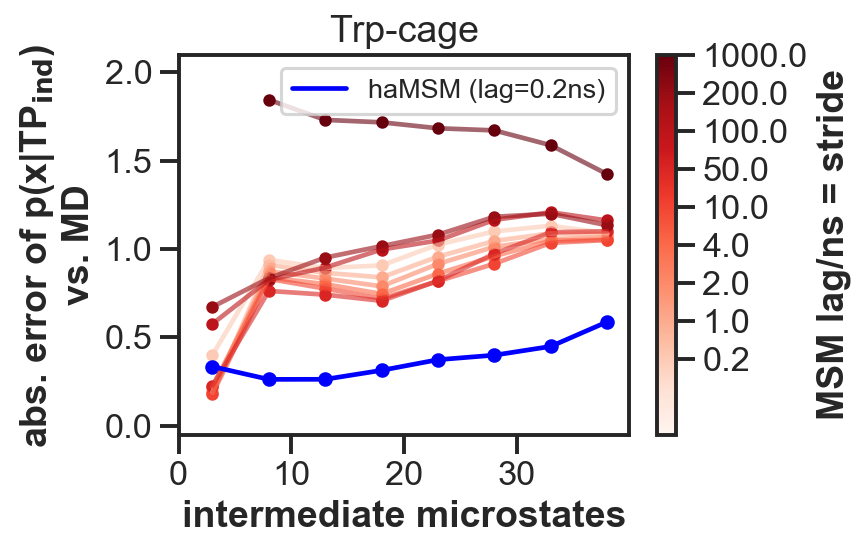

In [143]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs_strides[i][msm_index]) for i in range(len(counts_msms_cutoffs_strides))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')  

plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('abs. error of p(x|TP$_\mathbf{ind}$) \nvs. MD', weight='bold')
plt.xticks(range(0,40,10))
plt.ylim(-0.05,2.1)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: mean TP length (indirect paths only)

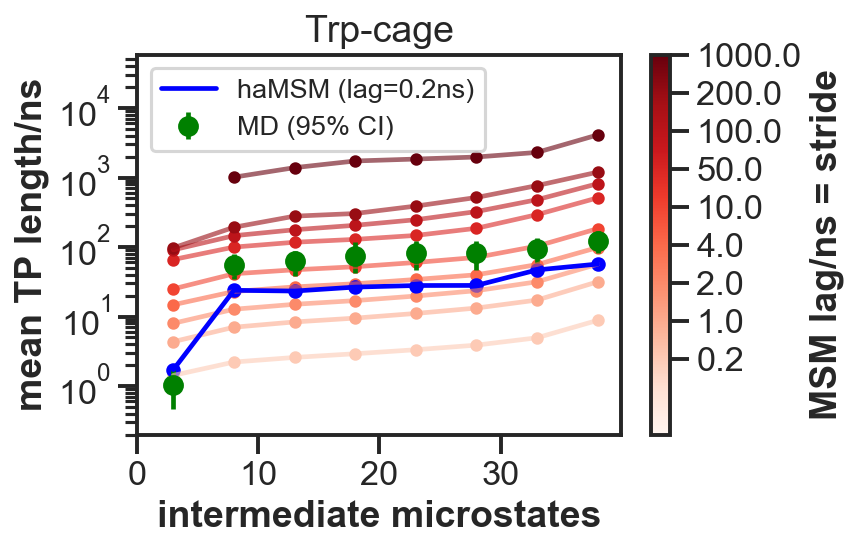

In [151]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs_strides])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold') 

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,40,10))
plt.ylim(0.2, 5.9e4)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()